<a href="https://colab.research.google.com/github/y001003/yeardream/blob/main/DL/torch/%EC%98%81%EC%88%98%EB%8B%98%EC%9D%98_%ED%98%B8%ED%9D%A1_01_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression - fetch_california_housing

In [ ]:
## import 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.datasets import fetch_california_housing

import torch
import torch.nn as nn ## Class Model(nn.Module):
from torch.utils.data import Dataset, DataLoader

# Dataset, DataLoader
# df --> Dataset : X, y --> DataLoader: Batch Size 

In [ ]:
ch = fetch_california_housing()

df = pd.DataFrame(ch.data, columns = ch.feature_names)
df['target'] = ch.target
print(df.shape)
df.head()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
class MyDataset(Dataset):
    def __init__(self, df = df):
        self.df = df # df -> Pandas DataFrame
        self.x = self.df.iloc[:, :-1].values # df.values -> numpy (np.array)
        self.y = self.df.iloc[:, -1:].values 

    ## Dataset 상속 -> Override 01: 전체 길이를 반환
    def __len__(self):
        return len(self.df) 

    ## Dataset 상속 -> Override 02: index
    def __getitem__(self, index):
        ## Reason: DataLoader - (20640 -->) 500, 500, 500, ..., 140 (index)
        # 1 ~ 20640 -> 500 Random --> a=[5, 2000, 3000, 9393, ...]: index -> Row 
        # Batch = df[a]

        x = self.x[index]
        y = self.y[index]
        # [1, 5, 200, 3, 4992, 33, 32]

        # numpy
        # return x, y

        # torch tensor로 리턴
        return torch.tensor(x, dtype = torch.float), torch.tensor(y, dtype = torch.float)

In [ ]:
import os
num = os.cpu_count()

In [ ]:
def prepare_loaders(df = df, 
                    index = 16640,
                    batch_size = 128):
    
    ## df -> Train, Valid
    train = df.iloc[:index, :].reset_index(drop = True)
    valid = df.iloc[index:, :].reset_index(drop = True) # reset_index --> DataLoader 에러

    ## Train, Valid --(MyDataset(Dataset))--> train_ds, valid_ds
    ## Column split
    train_ds = MyDataset(df =train)
    valid_ds = MyDataset(df =valid)

    ## train_ds, valid_ds --(DataLoader)--> train_loader, valid_loader
    ## Column split + Row SPlit -> (bs,8), (bs,1)
    train_loader = DataLoader(train_ds, 
                              batch_size = batch_size, # Batch_Size
                              num_workers = num, # n_jobs = -1
                              shuffle = True, # 섞기
                              drop_last = True, # 20,640 --> 1000개의 배치 ---> 640 나머지 버릴래 말래?
                              pin_memory = True) # 썰 -> 병목현상 역효과
    
    valid_loader = DataLoader(valid_ds, 
                              batch_size = batch_size, # Batch_Size
                              num_workers = num, # n_jobs = -1
                              shuffle = False, # 섞기
                              drop_last = False, # 20,640 --> 1000개의 배치 ---> 640 나머지 버릴래 말래?
                            #   pin_memory = True
                              ) # 썰 -> 병목현상 역효과
    print("DataLoader 만듦")
    return train_loader, valid_loader

train_loader, valid_loader = prepare_loaders(df = df, 
                                            index = 16640,
                                            batch_size = 128)

DataLoader 만듦


In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim = 8, output_dim = 1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, 16) # Shape: |(bs,  8)| -> |(bs, 16)|
        self.relu = nn.ReLU()               # Shape: |(bs, 16)| -> |(bs, 16)|
        self.fc2 = nn.Linear(16, 4)         # Shape: |(bs, 16)| -> |(bs, 4)|
        self.relu2 = nn.ReLU()              # Shape: |(bs, 4)| -> |(bs, 4)|
        self.fc3 = nn.Linear(4, output_dim) # Shape: |(bs, 4)| -> |(bs, 1)|

    ## nn.Module 상속시 반드시 하는 거
    def forward(self, x):
        # X: input_data -> |(bs, 8)| 
        output = self.fc3(self.relu2(self.fc2(self.relu(self.fc1(x)))))
        return output

In [ ]:
# 외우세여
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

## Colab -> GPU
model = Model(input_dim = 8, output_dim = 1).to(device)
model

Model(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=4, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
a = torch.randn(2, 3)
a

tensor([[-0.6926,  1.3996,  0.4593],
        [-0.1313,  0.3579,  1.4502]])

In [ ]:
b = a.to(device)
b

tensor([[-0.6926,  1.3996,  0.4593],
        [-0.1313,  0.3579,  1.4502]], device='cuda:0')

In [ ]:
## Loss Function, Optimizer
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),
                            #  lr = 1e-2 # Adam lr을 알아서 찾아가기 때문에 안 해줘도 상관은 없습니다.
                             )
## NLP AdamW -> lr = 1e-5, 5e-5

In [ ]:
# ## 개념도

# # 3. run_train
# for epoch in range(n_epochs):
#     # 1 epoch: 전체 데이터를 한 번 훑었을 때
#     # iteration: 전체 데이터 / Batch Size (예시: 2000 / 100 == 10) --> Model Update 횟수

#     # 1. train_one_epoch
#     train_loader -> train_loss -> Model 학습 O -> N번 만큼 모델이 업데이트

#     # 2. valid_one_epoch
#     valid_loader -> valid_loss -> Model 학습 X -> Only 성능 검증

#     # print_iter --> 주기적인 모니터링 

#     # Lowest Loss 갱신

#     # early_stop



In [ ]:
# 1. train_one_epoch
def train_one_epoch(model = model,
                    dataloader = train_loader,
                    loss_fn = loss_fn,
                    optimizer = optimizer,
                    scheduler = None):
    
    ## Model 학습
    model.train()

    ## Train Loss 
    train_loss = 0
    max_norm = 5

    ## Train Loader
    for data in dataloader:
        ## data[0], data[1] 
        x_i = data[0].to(device) # |(bs, 8)| 
        y_true = data[1].to(device)
        y_pred = model(x_i)      #|(bs, 8)| ->|(bs, 1)|

        loss = loss_fn(y_pred, y_true)

        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        train_loss += float(loss) # loss.item()
    train_loss /= len(dataloader)

    ## Accuracy


    return train_loss

In [ ]:
## data[0], data[1] 
## df-> Dataset -> DataLoader -> train_loader
data = next(iter(train_loader))
print(data[0].shape, data[1].shape )

torch.Size([128, 8]) torch.Size([128, 1])


In [ ]:
data, label = next(iter(valid_loader))
print(data.shape, label.shape )

torch.Size([128, 8]) torch.Size([128, 1])


In [ ]:
# 2. valid_one_epoch

# Model 학습 X (3)
@torch.no_grad()
def valid_one_epoch(model = model,
                    dataloader = valid_loader,
                    loss_fn = loss_fn):
    
    ## Model 학습 X (1)
    model.eval()

    ## valid Loss 
    valid_loss = 0

    ## valid Loader

    ## Model 학습 X (2)
    with torch.no_grad():
        for data in dataloader:
            ## data[0], data[1] 
            x_i = data[0].to(device) #|(bs, 8)| 
            y_true = data[1].to(device)
            y_pred = model(x_i) #|(bs, 8)| ->|(bs, 1)|

            loss = loss_fn(y_pred, y_true)

            valid_loss += float(loss) # loss.item()
    valid_loss /= len(dataloader)

    return valid_loss

In [ ]:
import copy

In [ ]:
# 3. run_train
def run_train(model = model, 
              train_loader = train_loader,
              valid_loader = valid_loader,
              loss_fn = loss_fn,
              optimizer = optimizer,
              scheduler = None,
              n_epochs = 200,
              print_iter= 20,
              early_stop = 30,
              best_model = None):
    
    ## Train Loss, Valid Loss -> 줍줍 -> 트랙킹
    train_history, valid_history = [], []

    ## Lowest Loss, Lowest Loss
    lowest_loss = np.inf
    lowest_epoch = np.inf


    for epoch in range(n_epochs):
        # 1번 함수
        train_loss = train_one_epoch(model = model,
                                     dataloader = train_loader,
                                     loss_fn = loss_fn,
                                     optimizer = optimizer,
                                     scheduler = None)
        # 2번 함수
        valid_loss = valid_one_epoch(model = model,
                                     dataloader = valid_loader,
                                     loss_fn = loss_fn,)
        
        ## loss 줍줍
        train_history += [train_loss]
        valid_history.append(valid_loss)

        ## Print iter Monitoring
        if (epoch + 1) % print_iter == 0:
            print("Epoch[%d]| TL=%.3e | VL=%.3e | LL=%.3e" % (epoch +1, train_loss, valid_loss, lowest_loss))

        ## Lowest Loss 갱신 (+ Model 저장)
        ## Epoch = 100 -> Lowest Loss
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch
            # model 저장
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), './model.bin')
        else:
            ## Epoch 120 -> 갱신 X -> Epoch 121, 122, ....
            ## Epoch 130 -> 갱신 X -> break (early_stop = 30, lowest epoch = 100)
            if early_stop > 0 and early_stop + lowest_epoch < epoch + 1:
                print("넌 삽질 중")
                break

    print("The Best Validation Loss=%.3e at %d Epoch" % (lowest_loss, lowest_epoch))

    # model load
    model.load_state_dict(best_model)

    return model, train_history, valid_history

In [ ]:
model, train_history, valid_history = run_train(model = model, 
                                                train_loader = train_loader,
                                                valid_loader = valid_loader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer,
                                                scheduler = None,
                                                n_epochs = 200,
                                                print_iter= 20,
                                                early_stop = 30,
                                                best_model = None)

Epoch[20]| TL=5.982e-01 | VL=7.847e-01 | LL=6.427e-01
넌 삽질 중
The Best Validation Loss=6.427e-01 at 7 Epoch


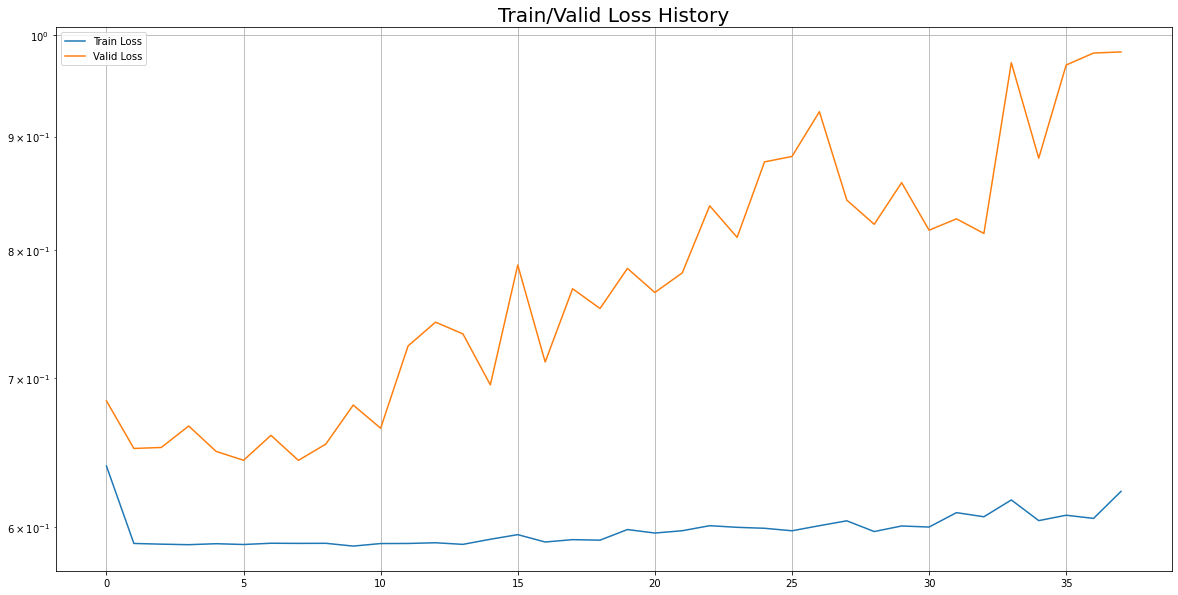

In [ ]:
# train_loss, validation loss 추이 시각화
plot_from = 0
plt.figure(figsize = (20, 10))
plt.title("Train/Valid Loss History", fontsize = 20)

plt.plot(range(0, len(train_history[plot_from:])), train_history[plot_from:], label ="Train Loss")
plt.plot(range(0, len(valid_history[plot_from:])), valid_history[plot_from:], label ="Valid Loss")

plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()